In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
np.random.seed(42)

## Modell:
$A\cdot\sin(x)=y$ mit $A$ $m\times n$-Matrix, $m$, $n$ beliebig ($A$ also insbesondere nicht zwingend quadratisch)

$x$ wird gesucht.

In [3]:
A = np.random.random(size = (100, 100))
x = np.random.random(size = (100, ))

In [4]:
y = np.dot(A, np.sin(x))

$A$ ist invertierbar:

In [5]:
if A.shape[0] == A.shape[1]:
    print(np.linalg.inv(A))

[[ 0.58611217  0.22754722  0.22079958 ... -0.35934623  0.66178901
   0.19085717]
 [-0.86053578  0.35823913 -0.05086583 ... -0.28753986  0.01246512
  -1.48921599]
 [ 0.26764428 -0.13717687 -0.92694754 ...  0.09591585 -1.22390556
   2.1684163 ]
 ...
 [ 0.66359634 -0.39434052  0.53305901 ...  0.12365094  0.66198343
   0.04954313]
 [-0.06110287  0.01871632 -0.28590078 ...  0.03731371 -0.48258655
   0.91014539]
 [-1.43651032  0.47662975 -0.21419412 ... -0.01676364  0.36827009
  -2.7539353 ]]


Verlustfunktion: mittlerer quadratischer Fehler $\frac{1}{n}\Vert y - \hat{y}\Vert^2$

In [6]:
from sklearn.metrics import mean_squared_error

Ableitung der Verlustfunktion nach den predictions $\hat{y}$ ist für ein $\hat{y}_i$: 

$-\frac{2}{n}(y_i-\hat{y}_i)$

In [7]:
def grad_loss(y_true, y_pred):
    return (-2) / y_true.shape[0] * (y_true - y_pred)

Loss, wenn der Mittelwert aller $y_i$ stets als prediction verwendet wird:

In [8]:
mean_squared_error(y, np.ones(y.shape[0])*np.mean(y))

1.8382635092906796

## EnKF-Algorithmus, wie ich ihn auch sonst implementiert habe

In [9]:
iterations = 100
particles = 100
randomization = True

In [10]:
h_0 = 2
epsilon = 0.5

In [11]:
# Dictionary, in das die Partikel (Vektoren, Schätzungen für x) geschrieben werden
param_dict = {}
# Dictionary, in das für alle Partikel die predictions für y geschrieben werden
y_pred_dict = {}
# Dictionary, in das für alle Partikel die Ableitungen der Verlustfunktion nach den predictions geschrieben werden
jacobian_dict = {}
# Dictionary, das für alle Partikel die Werte der Verlustfunktion enthält
loss_dict = {}

Initialisierung durch eine Normalverteilung und erste Auswertung:

In [12]:
for i in range(particles):
    param_dict["particle_{}".format(i+1)] = np.random.normal(loc = 0, scale = 1, size = x.shape)
    y_pred_dict["particle_{}".format(i+1)] = np.dot(A, np.sin(param_dict["particle_{}".format(i+1)]))
    jacobian_dict["particle_{}".format(i+1)] = grad_loss(y, y_pred_dict["particle_{}".format(i+1)])
    loss_dict["particle_{}".format(i+1)] = mean_squared_error(y, y_pred_dict["particle_{}".format(i+1)])

Mittelwerte aller Parameter der Partikel für die endgültige Schätzung von x:

In [13]:
param_mean = np.mean(list(param_dict.values()), axis = 0)

Loss für die gemittelten Parameter fortlaufend notieren:

In [14]:
loss_evolution = []
loss_evolution.append(mean_squared_error(y, np.dot(A, np.sin(param_mean))))

In [15]:
# zum Testen der einzelnen Partikel
loss_evolution_single_dict = {}
for i in range(particles):
    loss_evolution_single_dict["particle_{}".format(i+1)] = [mean_squared_error(y, np.dot(A, np.sin(param_dict["particle_{}".format(i+1)])))]

### EnKF

In [16]:
for iteration in range(iterations):
    
    # update the predictions, jacobian and loss for the new parameters
    for i in range(particles):
        y_pred_dict["particle_{}".format(i+1)] = np.dot(A, np.sin(param_dict["particle_{}".format(i+1)]))
        jacobian_dict["particle_{}".format(i+1)] = grad_loss(y, y_pred_dict["particle_{}".format(i+1)])
        loss_dict["particle_{}".format(i+1)] = mean_squared_error(y, y_pred_dict["particle_{}".format(i+1)])
    
    # compute the mean of the predictions
    y_pred_mean = np.mean(list(y_pred_dict.values()), axis = 0)
    
    # compute the matrix D elementwise
    d = np.zeros(shape = (particles, particles))
    for k in range(particles):
        y_pred_centered = y_pred_dict["particle_{}".format(str(k+1))] - y_pred_mean
        for j in range(particles):
            d[k][j] = np.dot(y_pred_centered, jacobian_dict["particle_{}".format(str(j+1))])
           
    # compute the scalar h_t
    h_t = h_0 / (np.sqrt(np.sum(d**2)) + epsilon)
        
    # matrix with particle parameters as row vectors
    params_all_ptcls = np.array(list(param_dict.values()))
    
    # compute the matrix with the updates for each particle
    params_all_ptcls = params_all_ptcls - h_t * np.dot(d, params_all_ptcls)
    
    # write the updates back into the dictionary
    for i in range(particles):
        param_dict["particle_{}".format(str(i+1))] = params_all_ptcls[i]
        if randomization:
            # add randomization/ noise to each particle
            stddev = 0.1
            noise = np.random.normal(loc = 0.0,
                                     scale = stddev,
                                     size = param_dict["particle_{}".format(str(i+1))].shape)
            new_param = param_dict["particle_{}".format(str(i+1))] + noise
            param_dict["particle_{}".format(str(i+1))] = new_param
    if randomization:
        # randomize particles around their mean
        param_dict_mean = list(np.mean(list(param_dict.values()), axis = 0))
        for i in range(particles):
            stddev = 0.1
            noise = np.random.normal(loc = 0.0,
                                     scale = stddev,
                                     size = param_dict["particle_{}".format(str(i+1))].shape)
            new_params = param_dict_mean + noise
            param_dict["particle_{}".format(str(i+1))] = new_params
    
    # compute loss for the parameter means
    param_mean = np.mean(params_all_ptcls, axis = 0)
    loss_evolution.append(mean_squared_error(y, np.dot(A, np.sin(param_mean))))
    
    # zum Testen der einzelnen Partikel
    for i in range(particles):
        loss_evolution_single_dict["particle_{}".format(i+1)].append(mean_squared_error(y, np.dot(A, np.sin(param_dict["particle_{}".format(i+1)]))))

Mit Randomization: Loss schwankt ungleichmäßig.

Ohne Randomization: Loss bleibt gleich ?!

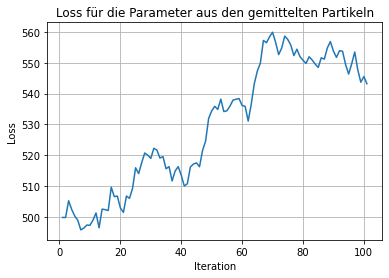

In [17]:
plt.plot(np.arange(len(loss_evolution))+1, loss_evolution)
plt.grid()
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss für die Parameter aus den gemittelten Partikeln")
plt.show()

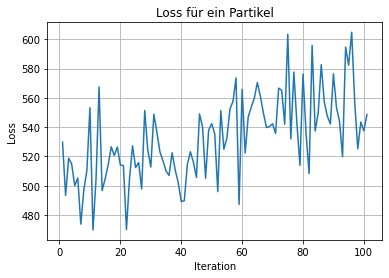

In [18]:
plt.plot(np.arange(len(loss_evolution_single_dict["particle_1"]))+1, loss_evolution_single_dict["particle_1"])
plt.grid()
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss für ein Partikel")
plt.show()

## EnKF wie für inverse Probleme

In [198]:
noise = False
y = np.dot(A, np.sin(x))
stddev_noise = np.ones(shape = y.shape)
if noise:
    noises = np.random.normal(loc = 0, scale = stddev_noise, size = y.shape)
    y = y + noises
    gamma = np.diag(stddev_noise**2)

In [199]:
batch = True
if batch:
    epochs = 10
    batch_size = int(np.floor(y.shape[0] / 10))         
else:
    epochs = 100
    batch_size = y.shape[0]

In [200]:
particles = 1000
epochs = 20
batch_size = 10

In [201]:
n = y.shape[0]
num_batches = int(np.ceil(n / batch_size))
batch_indices = np.cumsum([0] + list(np.ones(num_batches) * batch_size))
batch_indices[-1] = n

In [202]:
# Dictionary, in das die Partikel (Vektoren, Schätzungen für x) geschrieben werden
param_dict = {}
# Dictionary, in das für alle Partikel die predictions für y geschrieben werden
y_pred_dict = {}
# Dictionary, das für alle Partikel die Werte der Verlustfunktion enthält
loss_dict = {}

In [203]:
for i in range(particles):
    param_dict["particle_{}".format(i+1)] = np.random.normal(loc = 0, scale = 1, size = x.shape)
    y_pred_dict["particle_{}".format(i+1)] = np.dot(A, np.sin(param_dict["particle_{}".format(i+1)]))
    loss_dict["particle_{}".format(i+1)] = mean_squared_error(y, y_pred_dict["particle_{}".format(i+1)])

In [204]:
param_mean = np.mean(list(param_dict.values()), axis = 0)

In [205]:
loss_evolution = []
loss_evolution.append(mean_squared_error(y, np.dot(A, np.sin(param_mean))))

In [206]:
# zum Testen der einzelnen Partikel
loss_evolution_single_dict = {}
for i in range(particles):
    loss_evolution_single_dict["particle_{}".format(i+1)] = [mean_squared_error(y, np.dot(A, np.sin(param_dict["particle_{}".format(i+1)])))]

In [207]:
for epoch in range(epochs):

    A_batches = [A[int(batch_indices[i]):int(batch_indices[i+1])] for i in range(num_batches)]
    y_batches = [y[int(batch_indices[i]):int(batch_indices[i+1])] for i in range(num_batches)]
    if noise:
        gamma_batches = [gamma[int(batch_indices[i]):int(batch_indices[i+1]),int(batch_indices[i]):int(batch_indices[i+1])] for i in range(num_batches)]
    
    for b in range(num_batches):

        # update the predictions and the loss for the new parameters
        for i in range(particles):
            y_pred_dict["particle_{}".format(i+1)] = np.dot(A_batches[b], np.sin(param_dict["particle_{}".format(i+1)]))
            loss_dict["particle_{}".format(i+1)] = mean_squared_error(y_batches[b], y_pred_dict["particle_{}".format(i+1)])

        # compute the mean of the predictions
        y_pred_mean = np.mean(list(y_pred_dict.values()), axis = 0)

        # compute the matrices C
        param_diff_dict = {}
        pred_diff_param_dict = {}
        pred_diff_w_dict = {}
        c_param_w_dict = {}
        c_w_w_dict = {}

        for i in range(particles):
            param_diff_dict["particle_{}".format(str(i+1))] = param_dict["particle_{}".format(str(i+1))] - param_mean
            pred_diff_param_dict["particle_{}".format(str(i+1))] = y_pred_dict["particle_{}".format(str(i+1))] - y_pred_mean
            pred_diff_w_dict["particle_{}".format(str(i+1))] = y_pred_dict["particle_{}".format(str(i+1))] - y_pred_mean
        for i in range(particles):
            param_diff_dict["particle_{}".format(str(i+1))] = np.transpose(np.tile(param_diff_dict["particle_{}".format(str(i+1))], (pred_diff_param_dict["particle_{}".format(str(i+1))].shape[0], 1)))
            pred_diff_param_dict["particle_{}".format(str(i+1))] = np.tile(pred_diff_param_dict["particle_{}".format(str(i+1))], (param_diff_dict["particle_{}".format(str(i+1))].shape[0], 1))
            pred_diff_w_dict["particle_{}".format(str(i+1))] = np.tile(pred_diff_w_dict["particle_{}".format(str(i+1))], (pred_diff_w_dict["particle_{}".format(str(i+1))].shape[0], 1))
            c_param_w_dict["particle_{}".format(str(i+1))] = param_diff_dict["particle_{}".format(str(i+1))] * pred_diff_param_dict["particle_{}".format(str(i+1))]
            c_w_w_dict["particle_{}".format(str(i+1))] = pred_diff_w_dict["particle_{}".format(str(i+1))] * pred_diff_w_dict["particle_{}".format(str(i+1))]
        c_param_w = np.mean(list(c_param_w_dict.values()), axis = 0)
        c_w_w = np.mean(list(c_w_w_dict.values()), axis = 0)

        # write the updates back into the dictionary
        for i in range(particles):
            if noise:
                param_dict["particle_{}".format(str(i+1))] = param_dict["particle_{}".format(str(i+1))] + np.dot(np.dot(c_param_w, np.linalg.pinv(c_w_w + gamma_batches[b])), y_batches[b] - y_pred_dict["particle_{}".format(str(i+1))])
            else:
                param_dict["particle_{}".format(str(i+1))] = param_dict["particle_{}".format(str(i+1))] + np.dot(np.dot(c_param_w, np.linalg.pinv(c_w_w)), y_batches[b] - y_pred_dict["particle_{}".format(str(i+1))])

        # compute loss for the parameter means
        param_mean = np.mean(list(param_dict.values()), axis = 0)
        loss_evolution.append(mean_squared_error(y, np.dot(A, np.sin(param_mean))))

        # zum Testen der einzelnen Partikel
        for i in range(particles):
            loss_evolution_single_dict["particle_{}".format(i+1)].append(mean_squared_error(y, np.dot(A, np.sin(param_dict["particle_{}".format(i+1)]))))

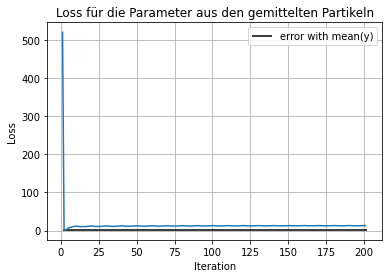

In [208]:
plt.hlines(y = mean_squared_error(y, np.ones(y.shape[0])*np.mean(y)), xmin = 1, xmax = len(loss_evolution)+1, color = "black", label = "error with mean(y)")
plt.plot(np.arange(len(loss_evolution))+1, loss_evolution)
plt.grid()
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss für die Parameter aus den gemittelten Partikeln")
plt.show()

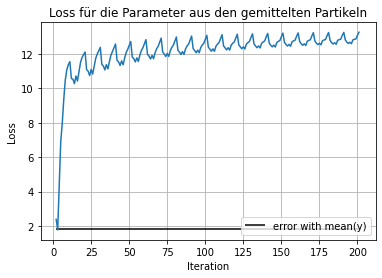

In [209]:
# ohne den initialen Guess
plt.hlines(y = mean_squared_error(y, np.ones(y.shape[0])*np.mean(y)), xmin = 2, xmax = len(loss_evolution)+1, color = "black", label = "error with mean(y)")
plt.plot(np.arange(len(loss_evolution))[1:]+1, loss_evolution[1:])
plt.grid()
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss für die Parameter aus den gemittelten Partikeln")
plt.show()

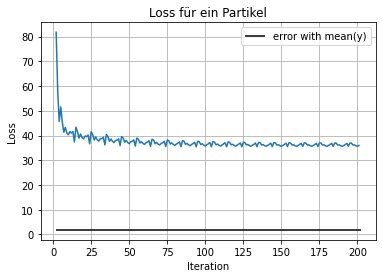

In [210]:
# ohne den initialen Guess
plt.hlines(y = mean_squared_error(y, np.ones(y.shape[0])*np.mean(y)), xmin = 2, xmax = len(loss_evolution)+1, color = "black", label = "error with mean(y)")
plt.plot(np.arange(len(loss_evolution_single_dict["particle_1"]))[1:]+1, loss_evolution_single_dict["particle_1"][1:])
plt.grid()
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss für ein Partikel")
plt.show()

In [211]:
np.dot(A, np.sin(param_mean))

array([24.5994905 , 26.29638392, 28.22075048, 25.97695162, 27.03211959,
       27.81283381, 23.47704257, 28.13853534, 24.38427491, 25.47414502,
       28.73731908, 29.57952884, 24.87489802, 27.83106459, 27.6357852 ,
       26.65339254, 27.36148533, 24.85821971, 28.52550408, 25.88689586,
       26.8216781 , 28.16099261, 26.08826842, 25.86668904, 27.13364336,
       27.25933593, 24.95530214, 26.58987999, 26.85911258, 29.27249292,
       25.53972645, 26.70436123, 24.54742424, 27.0224223 , 28.83983597,
       25.82911507, 24.69289583, 26.83613308, 27.63990706, 24.65615908,
       26.52134718, 26.46453287, 25.64964333, 25.31980746, 26.51273599,
       27.38974591, 28.74890899, 24.80638783, 25.40756676, 28.73661376,
       25.2705629 , 27.40504258, 26.20065351, 27.56478534, 25.95903765,
       26.72042752, 25.89210279, 28.02219023, 26.68320047, 27.41601562,
       26.57798198, 23.82157786, 27.40494651, 26.83964968, 27.25670333,
       26.19213375, 26.08916844, 26.9481553 , 26.932812  , 26.15

In [212]:
y

array([22.88352754, 22.12449329, 24.02806775, 22.12689643, 22.65910868,
       25.67840114, 19.78810564, 24.70478571, 20.48440945, 21.34591231,
       25.10658433, 26.1740027 , 22.27105294, 25.35017368, 23.95557332,
       22.79232607, 23.84765927, 22.27152225, 24.67129512, 22.26636163,
       23.55444323, 23.8573644 , 22.38047398, 23.68117761, 24.55555825,
       22.82574383, 20.80978045, 23.37155181, 23.94089535, 24.62438132,
       22.48885615, 22.76498133, 21.57431582, 23.94844507, 25.29435255,
       23.165074  , 20.86422703, 23.14715763, 23.45920582, 20.27321644,
       23.14400469, 23.16303838, 22.3881781 , 22.38123009, 23.21004727,
       23.57100682, 24.33027944, 21.96268777, 21.22283784, 24.36549923,
       21.45615549, 23.79390882, 22.71782302, 23.91218695, 22.05677576,
       22.59341811, 22.57434259, 24.24943966, 22.82729318, 24.18567295,
       24.08183533, 21.35859538, 23.80120102, 23.01729763, 24.07373004,
       21.84858145, 23.00308402, 24.1994118 , 21.70121527, 22.64

In [213]:
print("Error mit Mittelwert als prediction: {}".format(mean_squared_error(y, np.ones(y.shape[0])*np.mean(y))))
print("Final model error: {}".format(loss_evolution[-1]))

Error mit Mittelwert als prediction: 1.8382635092906796
Final model error: 13.258727281070021
